# Classification models to predict the property prices in Greater Toronto Area.

We categorize our entire dataset into three levels. The first level, assigned with a value of 0 will indicate a property price less that 0.8 million dollars. The second level, assigned with a value of 1 will indicate a property price in the range of 0.8-1.6 million dollars. And finally, the third level, assigned with a value of 2 will indicate a property price greater than 1.6 million dollars. 

Load the required Python packages.



In [1]:
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

Start the clock for estimating the code execution time.



In [2]:
t0 = time.time()

# Load the dataset.

In [3]:
path = os.getcwd() +"/clean_combined_toronto_property_data.xlsx"
data = pd.read_excel(path)
print(data.shape)
data.head()

(7324, 6)


,price,region,address,bedrooms,bathrooms,pricem
0,799000,"Ajax, ON","2 ROLLO DR, Ajax, Ontario",3,3,0.799000
1,989000,"Ajax, ON","717 OLD HARWOOD AVE, Ajax, Ontario",2,1,0.989000
2,999900,"Ajax, ON","52 ADDLEY CRES, Ajax, Ontario",3,4,0.999900
3,799900,"Ajax, ON","249 MONARCH AVE, Ajax, Ontario",3,3,0.799900
4,899999,"Ajax, ON","18 MONK CRES, Ajax, Ontario",3,3,0.899999


# Data Cleaning.

Drop the **address** column from the dataset.

In [4]:
data.drop(columns= ["address"], inplace= True)
print(data.shape)
data.head()

(7324, 5)


,price,region,bedrooms,bathrooms,pricem
0,799000,"Ajax, ON",3,3,0.799000
1,989000,"Ajax, ON",2,1,0.989000
2,999900,"Ajax, ON",3,4,0.999900
3,799900,"Ajax, ON",3,3,0.799900
4,899999,"Ajax, ON",3,3,0.899999


Remove ", ON" from each region name in the **region** column.

In [5]:
data["region"] = data["region"].str.replace(",", "")
data["region"] = data["region"].str.replace("ON", "")
data.head()

,price,region,bedrooms,bathrooms,pricem
0,799000,Ajax,3,3,0.799000
1,989000,Ajax,2,1,0.989000
2,999900,Ajax,3,4,0.999900
3,799900,Ajax,3,3,0.799900
4,899999,Ajax,3,3,0.899999


Check missing values.

In [6]:
data.isna().sum()

price        0
region       0
bedrooms     0
bathrooms    0
pricem       0
dtype: int64

Keep properties with at least one bedroom, and at least one bathroom.

In [7]:
data = data[data.bedrooms > 0]
data = data[data.bathrooms > 0]

In [8]:
data.shape

(7269, 5)

The no. of listings and median property price in each region.

In [9]:
data_region_lisitngs = data.drop(columns= ['bedrooms', 'bathrooms', 'pricem'])
data_region_lisitngs = (((data_region_lisitngs.groupby(by = 'region').count()).reset_index()))
data_region_lisitngs.rename(columns= {'price' : 'no. of listings'}, inplace= True)

data_median = data.drop(columns= ['bedrooms', 'bathrooms', 'price'])
data_median = data_median.groupby(by= 'region').median().reset_index()
data_median.rename(columns= {"pricem" : "median price in million dollars"}, inplace= True)

pd.merge(data_median,data_region_lisitngs).sort_values(
    by = "median price in million dollars", ascending= False
).reset_index().drop(columns= "index")

,region,median price in million dollars,no. of listings
0,King,2.969000,56
1,Caledon,1.899000,132
2,Oakville,1.799450,422
3,Richmond Hill,1.698500,382
4,East Gwillimbury,1.688500,92
5,Aurora,1.688000,130
6,Whitchurch-Stouffville,1.499000,98
7,Markham,1.399450,482
8,Vaughan,1.399000,478
9,Halton Hills,1.397000,80


The exploratory data analysis showed that the region where the property is located, as well as the number of bedrooms and number of bathrooms a property has are important factors in deciding the listing price of the property.

Therefore, we would like to predict the price of a house using the three features, namely **region**, **bedrooms** and **bathrooms**.

In [10]:
print('The maximum price a house has in the dataframe is', max(data.pricem), 'Million dollars, while the minimum price is', min(data.pricem), 'Million dollars.')

The maximum price a house has in the dataframe is 27.975 Million dollars, while the minimum price is 0.359 Million dollars.


# Categorize the data into three levels.

Assign a label 0 to the properties with listing price less than 0.8 million dollars, a label 1 to the properties with listing price between 0.8 to 1.6 million dollars, and a label 2 to the properties with listing price more than 1.6 million dollars.

In [11]:
data['label'] = 0
data.loc[data.pricem < 0.8, 'label'] = 0
data.loc[data.pricem > 0.8, 'label'] = 1
data.loc[data.pricem > 1.6, 'label'] = 2
data.head()

,price,region,bedrooms,bathrooms,pricem,label
0,799000,Ajax,3,3,0.799000,0
1,989000,Ajax,2,1,0.989000,1
2,999900,Ajax,3,4,0.999900,1
3,799900,Ajax,3,3,0.799900,0
4,899999,Ajax,3,3,0.899999,1


In [12]:
print(
    'In the dataset, there are '+ str(sum(data.label == 0))+ " number of properties with a price less than 0.8 million dollars, " 
    + str(sum(data.label == 1))+ " number of properties with a price between 0.8 to 1.6 million dollars, and "
    + str(sum(data.label == 2))+ " number of properties with a price more than 1.6 million dollars"
)

In the dataset, there are 2047 number of properties with a price less than 0.8 million dollars, 3421 number of properties with a price between 0.8 to 1.6 million dollars, and 1801 number of properties with a price more than 1.6 million dollars


In [13]:
data.dtypes

price          int64
region        object
bedrooms       int64
bathrooms      int64
pricem       float64
label          int64
dtype: object

In [14]:
data.shape

(7269, 6)

# Data pre-processing.

Output variable

In [15]:
Y = data.label
print(len(Y))
Y

7269


0       0
1       1
2       1
3       0
4       1
       ..
7319    2
7320    0
7321    1
7322    0
7323    2
Name: label, Length: 7269, dtype: int64

In [16]:
Y.unique()

array([0, 1, 2])

Get dummy variables for the **region** column.

In [17]:
X = pd.get_dummies(data.drop(columns= ["price", "pricem", "label"]), prefix= 'region')
print(X.shape)
X.head()

(7269, 33)


,bedrooms,bathrooms,region_Ajax,region_Aurora,region_Brampton,region_Brantford,region_Brock,region_Burlington,region_Caledon,region_Cambridge,...,region_Old Toronto Toronto,region_Oshawa,region_Pickering,region_Richmond Hill,region_Scarborough Toronto,region_Scugog,region_Uxbridge,region_Vaughan,region_Whitby,region_Whitchurch-Stouffville
0,3,3,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,4,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,3,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3,3,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Split data into training and testing datasets.

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test  = train_test_split(X, Y, train_size= 0.80, random_state= 1)

In [19]:
d1 = pd.DataFrame({
    "property_label" : [0, 1, 2],
    "count" : [sum(Y_train == 0), sum(Y_train == 1), sum(Y_train == 2)],
    "data_type" : ["training", "training", "training"]
    
})
d1["proportion"] = d1["count"]/d1["count"].sum()

d2 = pd.DataFrame({
    "property_label" : [0, 1, 2],
    "count" : [sum(Y_test == 0), sum(Y_test == 1), sum(Y_test == 2)],
    "data_type" : ["testing", "testing", "testing"]
    
})
d2["proportion"] = d2["count"]/d2["count"].sum()

df_concat = pd.concat([d1, d2]).reset_index().drop(columns= ["index"])
df_concat

,property_label,count,data_type,proportion
0,0,1634,training,0.280997
1,1,2738,training,0.470851
2,2,1443,training,0.248151
3,0,413,testing,0.284044
4,1,683,testing,0.469739
5,2,358,testing,0.246217


In [20]:
train_size = 0.8
print("Training dataset contains " + str(train_size*100) + " %" + " of the total data.")

Training dataset contains 80.0 % of the total data.


In [21]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(5815, 33)
(1454, 33)
(5815,)
(1454,)


Text(0.5, 1.0, 'Proportion of Property Types')

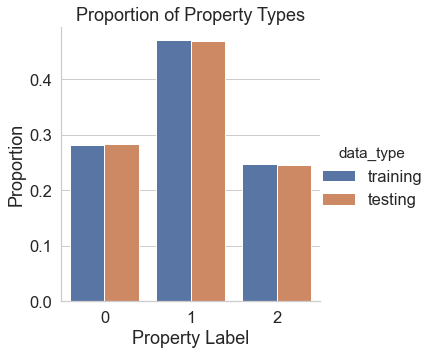

In [22]:
sns.set(font_scale=1.5)
sns.set_style('whitegrid')
sns.catplot(
    data = df_concat, 
    x = "property_label",
    y = "proportion",
    hue = "data_type",
    kind = "bar",
    height= 5
)
plt.xlabel('Property Label')
plt.ylabel('Proportion')
plt.title('Proportion of Property Types')

The above figure shows that both the training as well as testing datasets contain alomost the same amout of proportions of different propert labels.

# K-Nearest Neighbors Model.

In [23]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, Y_train)

KNeighborsClassifier()

In [24]:
accuracy_score(Y_test, knn.predict(X_test))

0.7097661623108665

GridSearchCV for hyperparameter tuning.

In [25]:
t1 = time.time()
parameters = {
    'n_neighbors' : range(1,30),
    'weights' : ('uniform', 'distance')
}
gs_knn = GridSearchCV(
    estimator= knn,
    param_grid= parameters,
    cv = 5,
    return_train_score= True
    )
gs_knn.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 30),
                         'weights': ('uniform', 'distance')},
             return_train_score=True)

In [26]:
time_knn = time.time()-t1
print('Hyperparameter tuning for the K-Nearest Neighbors model took', time_knn, 'seconds.')

Hyperparameter tuning for the K-Nearest Neighbors model took 136.4653811454773 seconds.


Best score obtained for the hyperparameter tuning cross-validation.

In [27]:
gs_knn.best_score_

0.7263972484952709

Best parameter values after the hyperparameter tuning.

In [28]:
gs_knn.best_params_

{'n_neighbors': 25, 'weights': 'uniform'}

In [29]:
gs_results  = pd.DataFrame(gs_knn.cv_results_)
gs_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_n_neighbors', 'param_weights', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score', 'split0_train_score', 'split1_train_score',
       'split2_train_score', 'split3_train_score', 'split4_train_score',
       'mean_train_score', 'std_train_score'],
      dtype='object')

In [30]:
gs_results = gs_results[['mean_test_score', 'mean_train_score', 'params']]
gs_results

,mean_test_score,mean_train_score,params
0,0.653482,0.687919,"{'n_neighbors': 1, 'weights': 'uniform'}"
1,0.653482,0.687919,"{'n_neighbors': 1, 'weights': 'distance'}"
2,0.674463,0.710404,"{'n_neighbors': 2, 'weights': 'uniform'}"
3,0.675838,0.717240,"{'n_neighbors': 2, 'weights': 'distance'}"
4,0.681513,0.719991,"{'n_neighbors': 3, 'weights': 'uniform'}"
5,0.682545,0.727730,"{'n_neighbors': 3, 'weights': 'distance'}"
6,0.686156,0.723818,"{'n_neighbors': 4, 'weights': 'uniform'}"
7,0.684953,0.734695,"{'n_neighbors': 4, 'weights': 'distance'}"
8,0.690800,0.733362,"{'n_neighbors': 5, 'weights': 'uniform'}"
9,0.690112,0.745314,"{'n_neighbors': 5, 'weights': 'distance'}"


Mean value for testing and training score after hyperparameter cross validation.

In [31]:
gs_results.loc[gs_results.params == gs_knn.best_params_]

,mean_test_score,mean_train_score,params
48,0.726397,0.737403,"{'n_neighbors': 25, 'weights': 'uniform'}"


K-Nearest Neighbors model accuracy with optimized parameters.

In [32]:
knn_optimized = KNeighborsClassifier(
    n_neighbors= gs_knn.best_params_['n_neighbors'],
    weights= gs_knn.best_params_['weights']
)

knn_optimized.fit(X_train, Y_train)
yhat_optimized = knn_optimized.predict(X_test)
accuracy_score(yhat_optimized, Y_test)

0.7379642365887208

Confusion Matrix for optimized K-Nearest Neighbors model.

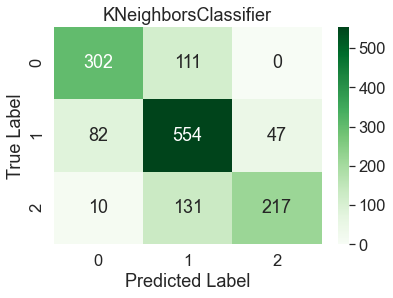

In [33]:
sns.set(font_scale= 1.5)
plt.figure(figsize= (6,4))
h =sns.heatmap(confusion_matrix(y_true= Y_test, y_pred= yhat_optimized), annot= True, cmap= 'Greens', fmt = 'g')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('KNeighborsClassifier');

# Random Forest Model.

In [34]:
rf = RandomForestClassifier(random_state= 1)
rf.fit(X_train, Y_train)
accuracy_score(rf.predict(X_test), Y_test)

0.7420907840440165

Optimizing number of trees values in the forest.

In [35]:
t2 = time.time()
train_accuracy = []
n_trees = np.arange(1, 50, 1)
for tree in n_trees:
    rf = RandomForestClassifier(n_estimators= tree, random_state= 1)
    rf.fit(X_train, Y_train)
    train_accuracy_iter = accuracy_score(rf.predict(X_train), Y_train)
    train_accuracy.append(train_accuracy_iter)
time_rf = time.time()-t2
print('Finding n_tree for the random forest model took', time_rf, 'seconds.')

Finding n_tree for the random forest model took 4.073160886764526 seconds.


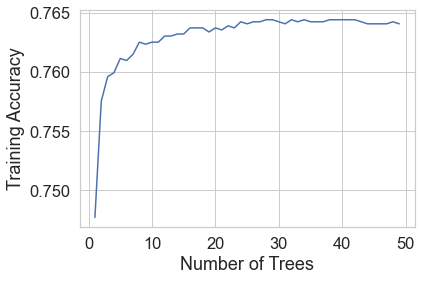

In [36]:
sns.set(font_scale= 1.5)
sns.set_style('whitegrid')
plt.figure(figsize= (6, 4))
sns.lineplot(x = n_trees, y =train_accuracy)
plt.xlabel('Number of Trees')
plt.ylabel('Training Accuracy');

In [37]:
print(max(train_accuracy))
array = n_trees[train_accuracy == max(train_accuracy)]
array

0.764402407566638


array([28, 29, 32, 34, 38, 39, 40, 41, 42])

Random forest model with optimized number of trees.



In [38]:
rf_optimized = RandomForestClassifier(
    n_estimators = array[0],
    random_state= 1
)
rf_optimized.fit(X_train, Y_train)

RandomForestClassifier(n_estimators=28, random_state=1)

Accuracy for the optimized Random forest model.



In [39]:
yhat_optimized = rf_optimized.predict(X_test)
accuracy_score(yhat_optimized, Y_test)

0.7434662998624484

Confusion matrix for the optimized Random forest model.

Text(0.5, 1.0, 'RandomForestClassifier')

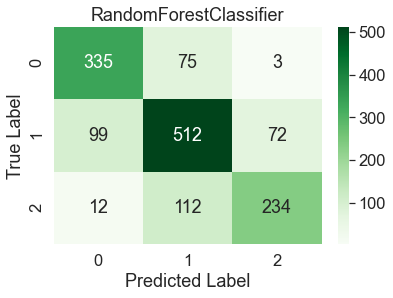

In [40]:
sns.set(font_scale= 1.5)
plt.figure(figsize= (6,4))
sns.heatmap(confusion_matrix(y_true= Y_test, y_pred= yhat_optimized), annot= True, cmap= 'Greens', fmt = 'g')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('RandomForestClassifier')

In [41]:
pd.DataFrame({
    "Model" : ["K-Nearest Neighbors", "Random Forest"],
    "Test split accuracy" : [accuracy_score(knn_optimized.predict(X_test), Y_test), accuracy_score(rf_optimized.predict(X_test), Y_test)]
})

,Model,Test split accuracy
0,K-Nearest Neighbors,0.737964
1,Random Forest,0.743466


In [42]:
print('The execution of entire code in the notebook (excluding time to load the packages) took', time.time()-t0, 'seconds.')

The execution of entire code in the notebook (excluding time to load the packages) took 143.59132075309753 seconds.


Author:

Mangaljit Singh